In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Features selection

In [2]:

df = pd.read_csv('preprocessed_train.csv')


In [3]:
# Sistemo i dati per regression tree

# One-Hot Encoding 
# nb: pd.get_dummies rimuove le colonne direttamente

# ## StoreId
# df = pd.get_dummies(df, columns=['StoreID'], prefix='StoreID')

df.drop('StoreID',axis=1)

 ## StoreType
df = pd.get_dummies(df, columns=['StoreType'], prefix='StoreType')

 ## AssortmentType
df = pd.get_dummies(df, columns=['AssortmentType'], prefix='AssortmentType')

# ## Region
df = pd.get_dummies(df, columns=['Region'], prefix='Region')

# ## Events
# df = pd.get_dummies(df, columns=['Events'], prefix='Events', dummy_na=True)
### inutile se possiamo usare categorie con decision tree

# numeric features to categories (strings)
#df.StoreID = df.StoreID.astype(str)
#df.Region = df.Region.astype(str)

In [4]:
df.iloc[0]

CloudCover                                      6
Events                                        NaN
HasPromotions                                   0
IsHoliday                                       0
IsOpen                                          1
Max_Dew_PointC                                 -2
Max_Gust_SpeedKm_h                             21
Max_Humidity                                   87
Max_Sea_Level_PressurehPa                    1009
Max_TemperatureC                                6
Max_VisibilityKm                               11
Max_Wind_SpeedKm_h                             21
Mean_Dew_PointC                                -3
Mean_Humidity                                  64
Mean_Sea_Level_PressurehPa                   1006
Mean_TemperatureC                               2
Mean_VisibilityKm                               8
Mean_Wind_SpeedKm_h                            13
Min_Dew_PointC                                 -6
Min_Humidity                                   34


In [5]:
# No-Events (NaN) are considered as sunny days, with lowest value (0) on the events scale
df['Events'] = df['Events'].fillna(0)

In [6]:
df=df.replace({'Rain':1, 'Thunderstorm':1, 'Fog':1, 'Snow': 2, 'Fog-Rain': 2, 'Rain-Thunderstorm': 2, 'Rain-Snow':2, 'Fog-Snow':2, 'Fog-Rain-Snow':3, 'Rain-Hail':3, 'Snow-Hail':3, 'Rain-Snow-Hail':3, 'Fog-Rain-Hail':3, 'Fog-Thunderstorm':3, 'Fog-Rain-Thunderstorm':4, 'Fog-Snow-Hail':4, 'Fog-Rain-Snow-Hail':4, 'Rain-Snow-Thunderstorm':4, 'Rain-Hail-Thunderstorm':4, 'Fog-Rain-Hail-Thunderstorm':4, 'Rain-Snow-Hail-Thunderstorm':4})

df['Events'].unique()

array([0, 1, 2, 3, 4])

In [7]:
df.iloc[0]

CloudCover                                      6.0
Events                                          0.0
HasPromotions                                   0.0
IsHoliday                                       0.0
IsOpen                                          1.0
Max_Dew_PointC                                 -2.0
Max_Gust_SpeedKm_h                             21.0
Max_Humidity                                   87.0
Max_Sea_Level_PressurehPa                    1009.0
Max_TemperatureC                                6.0
Max_VisibilityKm                               11.0
Max_Wind_SpeedKm_h                             21.0
Mean_Dew_PointC                                -3.0
Mean_Humidity                                  64.0
Mean_Sea_Level_PressurehPa                   1006.0
Mean_TemperatureC                               2.0
Mean_VisibilityKm                               8.0
Mean_Wind_SpeedKm_h                            13.0
Min_Dew_PointC                                 -6.0
Min_Humidity

In [8]:
# split trainset in data and target
y = df["NumberOfSales"]
X = df.drop('NumberOfSales', axis=1)

In [9]:
# Looking for features with NaN values
null_cols = []
print('Features with NaN:')
for col in X.columns:
    if X[col].isnull().values.any():
        print(col)
        null_cols.append(col)

Features with NaN:
Max_VisibilityKm
Mean_VisibilityKm
Min_VisibilitykM
IsOpen_yesterday
IsOpen_tomorrow
IsHoliday_yesterday
IsHoliday_tomorrow
NumberOfSales_yesterday
NumberOfSales_lastweek
NumberOfSales_lastmonth


In [10]:
# getting indices (rows) of all NaN values
inds = pd.isnull(X).any(1).nonzero()[0]

In [11]:
# drop all the rows with NaN values
y = y.drop(y.index[inds])
X = X.drop(X.index[inds])

In [12]:
# checking shapes
print('X: ' + str(X.shape))
print('y: ' + str(y.shape))

X: (414404, 56)
y: (414404,)


## Forest-Based features selection

In [13]:
# fit random forest with 250 trees
# forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest = RandomForestRegressor(n_estimators=250, random_state=0)
forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. feature 37 NumberOfSales_lastmonth (0.564279)
2. feature 2 HasPromotions (0.143255)
3. feature 35 NumberOfSales_yesterday (0.099028)
4. feature 36 NumberOfSales_lastweek (0.041700)
5. feature 31 IsOpen_yesterday (0.016117)
6. feature 27 DayOfWeek (0.014233)
7. feature 23 NearestCompetitor (0.013506)
8. feature 29 Week (0.011731)
9. feature 26 StoreID (0.010718)
10. feature 34 IsHoliday_tomorrow (0.004759)
11. feature 38 StoreType_Hyper Market (0.004665)
12. feature 25 Region_PopulationK (0.003985)
13. feature 28 Month (0.003776)
14. feature 32 IsOpen_tomorrow (0.003646)
15. feature 9 Max_TemperatureC (0.003617)
16. feature 19 Min_Humidity (0.003509)
17. feature 20 Min_Sea_Level_PressurehPa (0.003425)
18. feature 8 Max_Sea_Level_PressurehPa (0.003272)
19. feature 17 Mean_Wind_SpeedKm_h (0.002991)
20. feature 13 Mean_Humidity (0.002585)
21. feature 14 Mean_Sea_Level_PressurehPa (0.002566)
22. feature 6 Max_Gust_SpeedKm_h (0.002468)
23. feature 18 Min_Dew_PointC (0.002

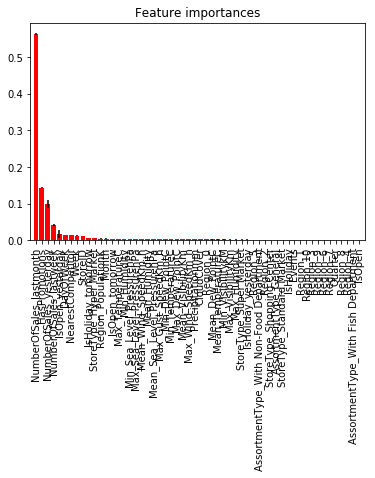

In [14]:
# preso pari pari dal notebook di Lanzi

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [15]:
feature_selection_model = SelectFromModel(forest, prefit=True)

In [16]:
X_selected_features_forest = feature_selection_model.transform(X)
X_selected_features_forest.shape

(414404, 4)

## PCA features selection

In [17]:
from sklearn.decomposition import PCA
%matplotlib inline

full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(X)

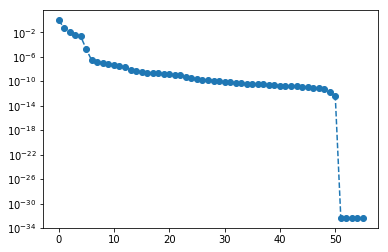

In [18]:
plt.semilogy(full_fitted_model.explained_variance_ratio_, '--o');

Text(0,0.5,'Cumulative Explained Variance Ratio')

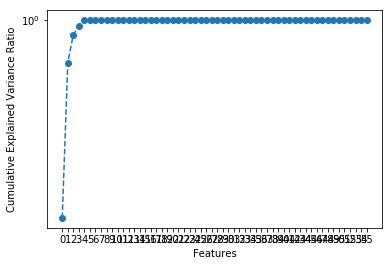

In [19]:
#Looking for a knee on the plot
plt.semilogy(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,56,1));
plt.xlabel("Features")
plt.ylabel("Cumulative Explained Variance Ratio")

In [20]:
# getting Principal (n) Components and reducing the dataset
feature_selection_pca_model = PCA(n_components=5)
fitted_model = feature_selection_pca_model.fit(X)
X_selected_features_pca = fitted_model.transform(X)
print("Explained Variance: %s" % fitted_model.explained_variance_ratio_)
print("Reduced data set shape is ", X_selected_features_pca.shape)

Explained Variance: [0.93098041 0.05381061 0.01003349 0.00305626 0.00210091]
Reduced data set shape is  (414404, 5)
